In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D
from keras.models import Sequential

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import cv2 


# Create Kill Banner for Binary Classifier

In [11]:
PATH = '/media/dolan/Backup Plus/Valorant/'
kill_flag = cv2.imread(PATH + 'kill.jpg')

In [12]:
#Video 



(180, 320, 3)


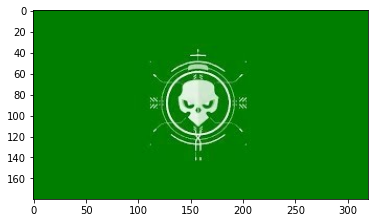

In [6]:
print(kill_flag.shape)
plt.imshow(kill_flag)

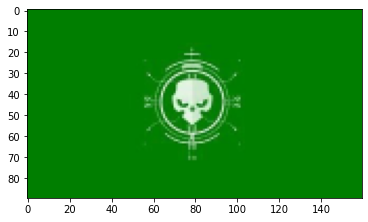

In [7]:
# kill_flag[kill_flag < 185] = 0
kill_flag = cv2.resize(kill_flag, (160, 90))
plt.imshow(kill_flag)

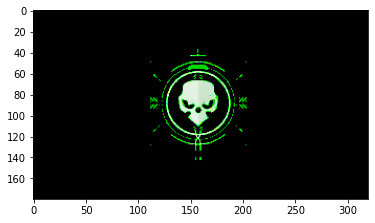

In [8]:
plt.imshow(kill_flag)

In [18]:
#rate = 1/30.0 
import os 
video_frames_path = '/media/dolan/Backup Plus/Valorant/frames/'

print(len(os.listdir(video_frames_path)))

num_frames =  len(os.listdir(video_frames_path)) 
time_elapsed = num_frames * 1./30.0

print(time_elapsed)

55353
1845.1


### Parse video data from Valorant clip. 

In [10]:
'''Uncomment if collecting videoframe data'''

# cap = cv2.VideoCapture(PATH + 'valorant1.mp4')
# i= 0
# while(cap.isOpened()):
#         ret, frame_ = cap.read()
#         if ret == False:
#             break
#         if i >= num_frames:
            
#             frame = cv2.resize(frame_, (320, 180))
#             cv2.imwrite(video_frames_path + 'frame'+str(i)+'.jpg',frame)
#         print('Created frame no. ' + str(i) + '...')
            
#         i+=1
# #     else:
# #         break

# cap.release()
# # Closes all the windows currently opened.
# cv2.destroyAllWindows()

'Uncomment if collecting videoframe data'

### Let's observe a sample image

In [19]:
sample_img = cv2.imread(video_frames_path + 'frame38350.jpg')

In [20]:
print(sample_img.shape)

(720, 1280, 3)


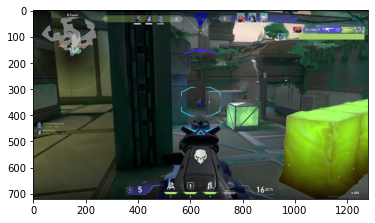

In [21]:
plt.imshow(sample_img)

In [22]:
sample_img = cv2.resize(sample_img, (320, 180))

In [23]:
(21 * 60 + 19) * 30

38370

In [24]:
#Slice the numpy array dude
arr = sample_img[130:150, :][:,150:170]

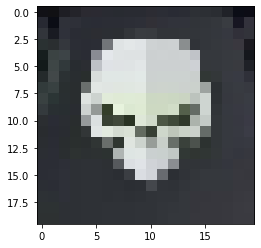

In [25]:
#We got the skull in range 130:150 and 150:170
#Double these parameters for double res for decent training 
plt.imshow(arr)

In [26]:
arr.shape

(20, 20, 3)

In [27]:
#Generate 
arr = cv2.resize(arr, (40, 40))

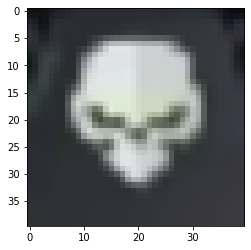

In [28]:
plt.imshow(arr)

In [29]:
print(np.max(arr), np.min(arr))

239 11


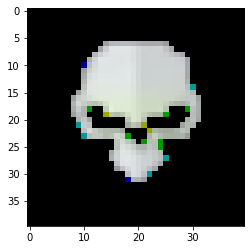

In [30]:
#Replace grey background with black, so we can more easily augment video frame training data
threshold=150
arr[arr < threshold] = 0

plt.imshow(arr)


In [31]:
np.max(arr)

239

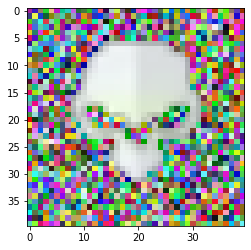

In [32]:
#Add bivariate gaussian noise

import random 


def add_noise(data, threshold, skull=True):
    if skull is True:
        data = data/np.max(data)
        
        for i in range(len(data)):
            for j in range(len(data[i])):
                if np.max(data[i][j]) == 0:
                    data[i][j] = np.random.rand(1,3)[0]
    else:
        val = np.random.rand(data.shape[0], data.shape[1], 3)
        data = np.float64(val)
    return data
noisy_arr = add_noise(arr, 19)
plt.imshow(noisy_arr)
    

In [33]:
noisy_arr.shape

(40, 40, 3)

# Data Preprocessing
# Process a ton of the video frames and pick out the region containing the skull... train a binary classifier on regions with a skull using artificially generated cases 

In [ ]:
def generate_data(arr, dataset_size, threshold=19):
    X_, y_ = [], []
    for i in range(dataset_size):
        
        skull = add_noise(arr, threshold)
        no_skull = add_noise(arr, threshold, False)
        #Containing the skull 
        X_.append(skull)
        y_.append(1)
        #Without the skull 
        X_.append(no_skull)
        y_.append(0)
        
    return np.array(X_), np.array(y_)


def generate_augmented_data(arr, dataset_size, has_skull):
    
        data = []
        for num in range(dataset_size):
            if num % 100 == 0:
                print("Oh, we're halfway there, oooowoooahh!")
                print("Livin' on a prayer!: ")
                print("Data added: ", num)
                
            video_sample = cv2.imread(video_frames_path + 'frame' + str(num) + '.jpg')
            video_sample = cv2.resize(video_sample, (320, 180))
            no_skull = video_sample[130:150, :][:,150:170] #Get the region where the skull would appear
            no_skull = cv2.resize(no_skull, (40,40))
            clone = arr
            with_skull = no_skull
            if has_skull is True:
                for i in range(len(clone)):
                    for j in range(len(clone[i])):

                        if clone[i][j].any() > 0.0:
                            with_skull[i][j] = clone[i][j]


                data.append([with_skull, 1])
                   
            else:
                data.append([no_skull, 0])
        
        return data
                
        
# X, y = generate_data(arr, 10000)        

# X, y = generate_augmented_data(arr, 1000)



images_with_skull = generate_augmented_data(arr, 5000, True)
images_without_skull = generate_augmented_data(arr, 5000, False)

data = images_with_skull + images_without_skull

# images_without_skull = generate_augmented_data(arr, 100, False)

In [37]:
def preprocess(data):
    
    X_, y_ = [], []
    for i in range(len(data)):
        
        X_.append(data[i][0])
        y_.append(data[i][1])
    
    return np.array(X_), np.array(y_)
        
for _ in range(5):
    random.shuffle(data)

training_data = data[:int(0.75 * len(data))]  
test_data = data[int(0.75 * len(data)):]

X_train, y_train = preprocess(training_data)
X_test, y_test = preprocess(test_data)



NameError: name 'data' is not defined

In [357]:
len(X_test)

2500

1


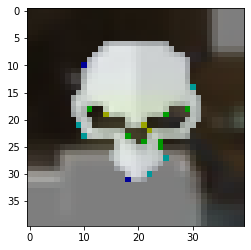

In [358]:
#We should find that images with a skull have a ground truth label y = 1
print(images_with_skull[0][1])
plt.imshow(images_with_skull[0][0])

0


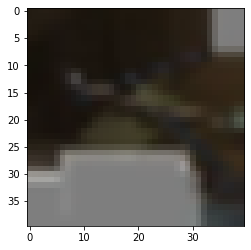

In [359]:
#Images with no skull should have a ground truth label y = 0 obviously 
print(images_without_skull[0][1])
plt.imshow(images_without_skull[0][0])

In [360]:
len(images_with_skull), len(images_without_skull)

(5000, 5000)

((40, 40, 3), 239)

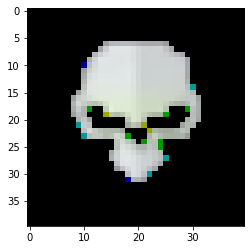

In [361]:
plt.imshow(arr)
arr.shape, np.max(arr)

In [362]:
sample_img.shape

(180, 320, 3)

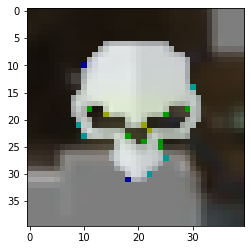

In [363]:
#Practice code for augmenting video data
video_sample = cv2.imread(video_frames_path + 'frame' + str(1315) + '.jpg')
video_sample = cv2.resize(video_sample, (320, 180))
no_skull = video_sample[130:150, :][:,150:170] #Get the region where the skull would appear
no_skull = cv2.resize(no_skull, (40,40))
clone = arr
with_skull = no_skull
for i in range(len(clone)):
    for j in range(len(clone[i])):

        if clone[i][j].any() > 0.0:
            with_skull[i][j] = clone[i][j]

# no_skull += clone

plt.imshow(with_skull)
        
        

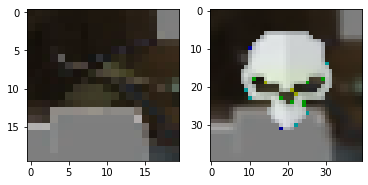

In [364]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(video_sample[130:150, :][:,150:170])
ax2.imshow(no_skull)

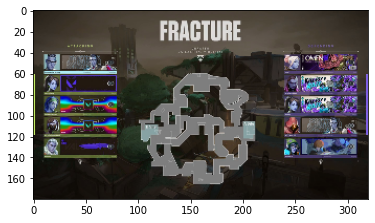

In [366]:
plt.imshow(video_sample)

# Develop, Tune , and also Train Deep Learning Model

In [367]:
# plt.imshow(X[1])
# X_train, X_test = X[:1500], X[1500:]
# y_train, y_test = y[:1500], y[1500:]

In [368]:
X_train.shape, y_train.shape

((7500, 40, 40, 3), (7500,))

In [13]:
model = keras.models.load_model('/home/dolan/Desktop/DataScience/kaggle/kill_cam.h5')
model.summary()

'''UNCOMMENT TO TRAIN A NEW MODEL'''
# model.add(Conv2D(filters=1, kernel_size=(3,3), input_shape=X_train.shape[1:]))

# model.add(Dropout(0.1))
# model.add(MaxPool2D(2,2))
# #Downsize the data to 20 * 20 convolutional layer
# model.add(Conv2D(filters=1, kernel_size=(3,3),input_shape=(20,20,3), activation='relu'))
# model.add(Dropout(0.1))
# model.add(MaxPool2D(2,2))

# model.add(Conv2D(filters=1, kernel_size=(3,3),input_shape=(20,20,3), activation='relu'))
# model.add(Dropout(0.1))
# model.add(MaxPool2D(2,2))

# model.add(Flatten())



# model.add(Dense(400, activation='relu' ))

# model.add(Dense(1, activation='sigmoid'))


# from keras.optimizers import Adam

# opt_ = Adam(learning_rate = 0.0001)

# EPOCHS = 10

# model.compile(optimizer='adam', loss='binary_crossentropy' ,  metrics=['accuracy'])

# history = model.fit(X_train, y_train, epochs=EPOCHS  , validation_data=(X_test, y_test))

2022-09-21 22:27:30.918542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dolan/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-21 22:27:30.918612: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 22:27:30.919161: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dolan-VivoBook-ASUSLaptop-X509DAP-M509DA): /proc/driver/nvidia/version does not exist
2022-09-21 22:27:30.959669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 38, 38, 1)         28        
                                                                 
 dropout_12 (Dropout)        (None, 38, 38, 1)         0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 19, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 17, 1)         10        
                                                                 
 dropout_13 (Dropout)        (None, 17, 17, 1)         0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 1)          0         
 g2D)                                                 

'UNCOMMENT TO TRAIN A NEW MODEL'

In [14]:
results = model.predict(X_test)

NameError: name 'X_test' is not defined

[[9.9999994e-01]
 [2.8771139e-03]
 [1.5541761e-04]
 [9.9999988e-01]
 [5.7632182e-10]
 [4.4925509e-05]
 [3.0811030e-02]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999267e-01]]


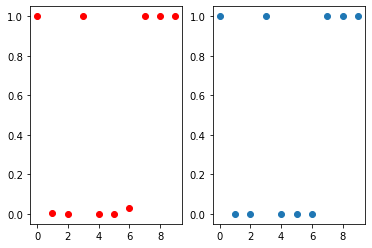

In [380]:
fig, ax = plt.subplots(1, 2)
Z = np.linspace(0, 9, 10)
ax[0].scatter(Z, results[:10], color='red')
ax[1].scatter(Z, y_test[:10])
print(results[:10])
#Jfc it's almost identical...

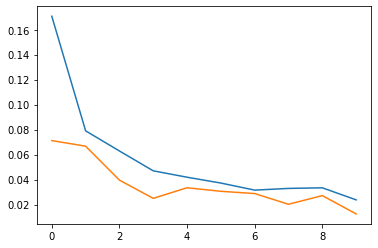

In [381]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
W = np.linspace(0, EPOCHS-1, EPOCHS)
plt.plot(W, training_loss)
plt.plot(W, validation_loss)



In [384]:
training_loss[-1]

0.023819098249077797

In [404]:
#Reviewing our original sample image from the video 
arr = sample_img[130:150, :][:,150:170]

arr = cv2.resize(arr, (40, 40))

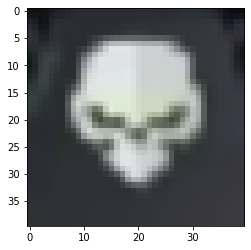

In [405]:
plt.imshow(arr)

In [406]:
arr = np.expand_dims(arr, axis=0)

In [407]:
arr.shape

(1, 40, 40, 3)

In [408]:
test_prediction = model.predict(arr)

1/1 [==============================] - 0s 24ms/step


In [409]:
test_prediction[0][0]
#It predicts with 100% certainty that there is a kill marker

0.9999955

In [410]:
# no_skull = arr
# no_skull[no_skull > 0] = 0
# plt.imshow(no_skull)

In [411]:
no_skull = np.expand_dims(no_skull, axis=0)
no_skull.shape

(1, 20, 20, 3)

In [412]:
# no_skull_pred = model.predict(no_skull)

In [413]:
# no_skull_pred
#Certainly not a low prediction value, but it's nowhere near certain definitely 

In [414]:
dims_arr = np.expand_dims(arr, axis=0)

In [415]:
# pred_on_og_image = model.predict(dims_arr)

In [416]:
# pred_on_og_image

In [417]:
def create_new_video_frames(video_frame_folder, compilation_images_folder):
    
    directory = os.listdir(video_frame_folder)
    
    
    compilation_image_count = 0
    
    for i in range(len(directory)):
        frame =  cv2.imread(video_frames_path + 'frame' + str(i) + '.jpg')
        # region_of_interest = cv2.resize(sample_img, (320, 180))
        region_of_interest = frame[520:590, :][:,600:685]#[130:150, :][:,150:170]
        region_of_interest = cv2.resize(region_of_interest, (40, 40))
        # input_ = cv2.resize(region_of_interest, )
        input_ = np.expand_dims(region_of_interest, axis=0)
        prediction = model.predict(input_)
        print(prediction[0][0])
        
        
        
#         if prediction > 0.5:
#             j = 0
#             while j < 150: #30 FPS * 5 seconds; write a ton of subsequent frames 
#                 cv2.imwrite(compilation_images_folder + 'killframe' + str(compilation_image_count) + '.jpg', frame)
#                 compilation_image_count += 1
#                 j += 1
#         else:
#             pass
    











In [536]:
region_of_interest.shape
# plt.imshow(region_of_interest)
# directory = os.listdir(video_frames_path)
# n = len(directory)
# m = n - 10
# print(n)
# for i in range(len(directory)):
#     frame =  cv2.imread(video_frames_path + 'frame' + str(i) + '.jpg')
#     # region_of_interest = cv2.resize(sample_img, (320, 180))
#     region_of_interest = frame[520:590, :][:,600:685]#[130:150, :][:,150:170]
#     region_of_interest = cv2.resize(region_of_interest, (40, 40))
#     # input_ = cv2.resize(region_of_interest, )
#     input_ = np.expand_dims(region_of_interest, axis=0)
#     prediction = model.predict(input_)
#     print(prediction[0][0])


#Writes all the kill frames into one folder 
def write_compilation_frames(video_frames_path, compilation_frames_path, starting_index, threshold):
    directory = os.listdir(video_frames_path)
    n = len(directory)
    frame_counter = 0
    
    j = 0
    i = starting_index
    
#     for i in range(starting_index, len(directory)):
    while i < len(directory):
        frame =  cv2.imread(video_frames_path + 'frame' + str(i) + '.jpg')
        # region_of_interest = cv2.resize(sample_img, (320, 180))
        region_of_interest = frame[520:590, :][:,600:685]#[130:150, :][:,150:170]
        region_of_interest = cv2.resize(region_of_interest, (40, 40))
        # input_ = cv2.resize(region_of_interest, )
        input_ = np.expand_dims(region_of_interest, axis=0)
        prediction = model.predict(input_)
#         print(prediction[0][0])
        if i % 100 == 0:
            print('Still lookin for dem killz...')
        if prediction[0][0] > threshold:
            print('Ladies and gentlemen, we gottem...')
            for j in range(150):
                kill_cam_frame = cv2.imread(video_frames_path + 'frame' + str(i + j) + '.jpg')
                cv2.imwrite(compilation_frames_path + 'kill' + str(frame_counter) + '.jpg', kill_cam_frame)
                frame_counter += 1
#                 i += 1#Update i pointer to skip ahead 
            i += 150 #Update i upon exiting the for loop so you don't go thru this data twice
        i += 1 #Iterate through while loop data
            
            
#         if prediction[0][0] > 0.5:
#                 print('We found a likelihood of: ', prediction[0][0], 'at ', frame_counter)
#                 cv2.imwrite(compilation_frames_path + 'kill' + str(frame_counter) + '.jpg', frame)
#                 frame_counter += 1 
        
            
    print('Finished')

In [488]:
arr = []
count = 0

for i in range(100):
    if i % 10 == 0:
        arr.append(i)
        count = 0
        for j in range(5):
            arr.append(i + j)
    
        
print(arr)

[0, 0, 1, 2, 3, 4, 10, 10, 11, 12, 13, 14, 20, 20, 21, 22, 23, 24, 30, 30, 31, 32, 33, 34, 40, 40, 41, 42, 43, 44, 50, 50, 51, 52, 53, 54, 60, 60, 61, 62, 63, 64, 70, 70, 71, 72, 73, 74, 80, 80, 81, 82, 83, 84, 90, 90, 91, 92, 93, 94]


In [38]:
#We know that there is a kill at frame3850.jpg

compilation_frames_path = '/media/dolan/Backup Plus/Valorant/compilation_images/'
video_frames_path = '/media/dolan/Backup Plus/Valorant/frames/'
write_compilation_frames(video_frames_path, compilation_frames_path, 38300, 0.95)

In [538]:
#Assess quality of obtained data

#Predict the probability of each frame being a kill frame, evaluate the maxima.
#Mean value of data should provide threshold for future data scraping


# predictions_ = []

# frame_path = compilation_frames_path + 'kill' + str(237) + '.jpg'
# print(frame_path)
# current = cv2.imread(frame_path)

# region_ = current[520:590, :][:,600:685]#[130:150, :][:,150:170]
# region_= cv2.resize(region_, (40, 40))
# # input_ = cv2.resize(region_of_interest, )
# input_ = np.expand_dims(region_, axis=0)
# prediction = model.predict(input_)
# print(prediction[0][0])
# predictions_.append(prediction[0][0])
# plt.imshow(current)

def assess_kills(compilation_frames_path):
    
    predictions_ = []
    for i in range(len(os.listdir(compilation_frames_path))):
        if i % 100 == 0:
            print('Almost dere...')
        frame_path = compilation_frames_path + 'kill' + str(i) + '.jpg'
        print(frame_path)
        current = cv2.imread(frame_path)
        
        region_ = current[520:590, :][:,600:685]#[130:150, :][:,150:170]
        region_= cv2.resize(region_, (40, 40))
        # input_ = cv2.resize(region_of_interest, )
        region_ = np.expand_dims(region_, axis=0)
        prediction = model.predict(region_)
        print(prediction[0][0])
        predictions_.append(prediction[0][0])
    return np.array(predictions_)
        
mean_probabilities =  assess_kills(compilation_frames_path)

Almost dere...
/media/dolan/Backup Plus/Valorant/compilation_images/kill0.jpg
1/1 [==============================] - 0s 17ms/step
0.9999946
/media/dolan/Backup Plus/Valorant/compilation_images/kill1.jpg
1/1 [==============================] - 0s 18ms/step
0.99999994
/media/dolan/Backup Plus/Valorant/compilation_images/kill2.jpg
1/1 [==============================] - 0s 20ms/step
4.4222417e-11
/media/dolan/Backup Plus/Valorant/compilation_images/kill3.jpg
1/1 [==============================] - 0s 20ms/step
1.3304922e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill4.jpg
1/1 [==============================] - 0s 18ms/step
1.2680805e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill5.jpg
1/1 [==============================] - 0s 19ms/step
3.913466e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill6.jpg
1/1 [==============================] - 0s 21ms/step
1.1379124e-07
/media/dolan/Backup Plus/Valorant/compilation_images/kill7.jpg
1/1 [======================

1/1 [==============================] - 0s 19ms/step
0.00018434794
/media/dolan/Backup Plus/Valorant/compilation_images/kill64.jpg
1/1 [==============================] - 0s 24ms/step
3.2436183e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill65.jpg
1/1 [==============================] - 0s 22ms/step
0.0017586731
/media/dolan/Backup Plus/Valorant/compilation_images/kill66.jpg
1/1 [==============================] - 0s 20ms/step
7.229535e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill67.jpg
1/1 [==============================] - 0s 28ms/step
0.0018981121
/media/dolan/Backup Plus/Valorant/compilation_images/kill68.jpg
1/1 [==============================] - 0s 24ms/step
0.0001695958
/media/dolan/Backup Plus/Valorant/compilation_images/kill69.jpg
1/1 [==============================] - 0s 21ms/step
0.003876481
/media/dolan/Backup Plus/Valorant/compilation_images/kill70.jpg
1/1 [==============================] - 0s 21ms/step
0.011052077
/media/dolan/Backup Plus/Valoran

1/1 [==============================] - 0s 20ms/step
0.013771913
/media/dolan/Backup Plus/Valorant/compilation_images/kill128.jpg
1/1 [==============================] - 0s 20ms/step
0.014477051
/media/dolan/Backup Plus/Valorant/compilation_images/kill129.jpg
1/1 [==============================] - 0s 21ms/step
0.0059555103
/media/dolan/Backup Plus/Valorant/compilation_images/kill130.jpg
1/1 [==============================] - 0s 21ms/step
0.006061252
/media/dolan/Backup Plus/Valorant/compilation_images/kill131.jpg
1/1 [==============================] - 0s 20ms/step
0.009474331
/media/dolan/Backup Plus/Valorant/compilation_images/kill132.jpg
1/1 [==============================] - 0s 22ms/step
0.017550068
/media/dolan/Backup Plus/Valorant/compilation_images/kill133.jpg
1/1 [==============================] - 0s 20ms/step
0.07293122
/media/dolan/Backup Plus/Valorant/compilation_images/kill134.jpg
1/1 [==============================] - 0s 22ms/step
0.08310443
/media/dolan/Backup Plus/Valorant/

1/1 [==============================] - 0s 20ms/step
2.2574357e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill191.jpg
1/1 [==============================] - 0s 22ms/step
1.0705414e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill192.jpg
1/1 [==============================] - 0s 21ms/step
9.991019e-07
/media/dolan/Backup Plus/Valorant/compilation_images/kill193.jpg
1/1 [==============================] - 0s 21ms/step
1.803194e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill194.jpg
1/1 [==============================] - 0s 21ms/step
2.769575e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill195.jpg
1/1 [==============================] - 0s 21ms/step
2.781083e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill196.jpg
1/1 [==============================] - 0s 20ms/step
2.781083e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill197.jpg
1/1 [==============================] - 0s 21ms/step
1.9590925e-06
/media/dolan/Backup Pl

1/1 [==============================] - 0s 23ms/step
1.1003335e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill254.jpg
1/1 [==============================] - 0s 22ms/step
0.0003119299
/media/dolan/Backup Plus/Valorant/compilation_images/kill255.jpg
1/1 [==============================] - 0s 18ms/step
9.912834e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill256.jpg
1/1 [==============================] - 0s 19ms/step
1.1269393e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill257.jpg
1/1 [==============================] - 0s 18ms/step
8.1160964e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill258.jpg
1/1 [==============================] - 0s 19ms/step
0.00142398
/media/dolan/Backup Plus/Valorant/compilation_images/kill259.jpg
1/1 [==============================] - 0s 19ms/step
0.0010677279
/media/dolan/Backup Plus/Valorant/compilation_images/kill260.jpg
1/1 [==============================] - 0s 20ms/step
2.9033197e-06
/media/dolan/Backup Plu

1/1 [==============================] - 0s 18ms/step
3.2851174e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill317.jpg
1/1 [==============================] - 0s 18ms/step
0.00019971846
/media/dolan/Backup Plus/Valorant/compilation_images/kill318.jpg
1/1 [==============================] - 0s 20ms/step
0.000114846815
/media/dolan/Backup Plus/Valorant/compilation_images/kill319.jpg
1/1 [==============================] - 0s 19ms/step
0.0002963391
/media/dolan/Backup Plus/Valorant/compilation_images/kill320.jpg
1/1 [==============================] - 0s 22ms/step
0.000115532894
/media/dolan/Backup Plus/Valorant/compilation_images/kill321.jpg
1/1 [==============================] - 0s 20ms/step
0.00013383476
/media/dolan/Backup Plus/Valorant/compilation_images/kill322.jpg
1/1 [==============================] - 0s 19ms/step
1.114282e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill323.jpg
1/1 [==============================] - 0s 18ms/step
4.3796797e-09
/media/dolan/Back

1/1 [==============================] - 0s 17ms/step
0.00069463643
/media/dolan/Backup Plus/Valorant/compilation_images/kill380.jpg
1/1 [==============================] - 0s 20ms/step
0.012057982
/media/dolan/Backup Plus/Valorant/compilation_images/kill381.jpg
1/1 [==============================] - 0s 17ms/step
0.014712721
/media/dolan/Backup Plus/Valorant/compilation_images/kill382.jpg
1/1 [==============================] - 0s 18ms/step
0.002739403
/media/dolan/Backup Plus/Valorant/compilation_images/kill383.jpg
1/1 [==============================] - 0s 20ms/step
0.00055332633
/media/dolan/Backup Plus/Valorant/compilation_images/kill384.jpg
1/1 [==============================] - 0s 18ms/step
5.3877848e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill385.jpg
1/1 [==============================] - 0s 19ms/step
0.0071016853
/media/dolan/Backup Plus/Valorant/compilation_images/kill386.jpg
1/1 [==============================] - 0s 20ms/step
0.0037704005
/media/dolan/Backup Plus/

1/1 [==============================] - 0s 19ms/step
7.413302e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill506.jpg
1/1 [==============================] - 0s 18ms/step
2.1655003e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill507.jpg
1/1 [==============================] - 0s 20ms/step
1.1114039e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill508.jpg
1/1 [==============================] - 0s 18ms/step
9.163649e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill509.jpg
1/1 [==============================] - 0s 23ms/step
6.097041e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill510.jpg
1/1 [==============================] - 0s 19ms/step
0.00035525314
/media/dolan/Backup Plus/Valorant/compilation_images/kill511.jpg
1/1 [==============================] - 0s 20ms/step
3.159096e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill512.jpg
1/1 [==============================] - 0s 20ms/step
6.5439e-06
/media/dolan/Backup Plus

1/1 [==============================] - 0s 22ms/step
5.9886047e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill569.jpg
1/1 [==============================] - 0s 20ms/step
7.6777615e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill570.jpg
1/1 [==============================] - 0s 20ms/step
8.672738e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill571.jpg
1/1 [==============================] - 0s 23ms/step
9.24687e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill572.jpg
1/1 [==============================] - 0s 20ms/step
1.1375264e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill573.jpg
1/1 [==============================] - 0s 23ms/step
1.0108509e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill574.jpg
1/1 [==============================] - 0s 20ms/step
1.3584536e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill575.jpg
1/1 [==============================] - 0s 20ms/step
1.7052502e-05
/media/dolan/Backup 

1/1 [==============================] - 0s 25ms/step
3.0662077e-11
/media/dolan/Backup Plus/Valorant/compilation_images/kill632.jpg
1/1 [==============================] - 0s 21ms/step
5.7580646e-10
/media/dolan/Backup Plus/Valorant/compilation_images/kill633.jpg
1/1 [==============================] - 0s 22ms/step
5.857122e-11
/media/dolan/Backup Plus/Valorant/compilation_images/kill634.jpg
1/1 [==============================] - 0s 21ms/step
4.5707237e-13
/media/dolan/Backup Plus/Valorant/compilation_images/kill635.jpg
1/1 [==============================] - 0s 19ms/step
3.4519407e-09
/media/dolan/Backup Plus/Valorant/compilation_images/kill636.jpg
1/1 [==============================] - 0s 17ms/step
7.377042e-12
/media/dolan/Backup Plus/Valorant/compilation_images/kill637.jpg
1/1 [==============================] - 0s 18ms/step
2.4549425e-12
/media/dolan/Backup Plus/Valorant/compilation_images/kill638.jpg
1/1 [==============================] - 0s 17ms/step
5.97517e-12
/media/dolan/Backup P

1/1 [==============================] - 0s 24ms/step
3.6966532e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill695.jpg
1/1 [==============================] - 0s 21ms/step
1.100323e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill696.jpg
1/1 [==============================] - 0s 21ms/step
3.235189e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill697.jpg
1/1 [==============================] - 0s 19ms/step
2.4232422e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill698.jpg
1/1 [==============================] - 0s 22ms/step
1.4017205e-05
/media/dolan/Backup Plus/Valorant/compilation_images/kill699.jpg
1/1 [==============================] - 0s 22ms/step
1.47158225e-05
Almost dere...
/media/dolan/Backup Plus/Valorant/compilation_images/kill700.jpg
1/1 [==============================] - 0s 22ms/step
1.0168823e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill701.jpg
1/1 [==============================] - 0s 23ms/step
0.00012341165
/me

1/1 [==============================] - 0s 18ms/step
7.4430446e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill758.jpg
1/1 [==============================] - 0s 17ms/step
7.4678055e-11
/media/dolan/Backup Plus/Valorant/compilation_images/kill759.jpg
1/1 [==============================] - 0s 17ms/step
2.6877949e-09
/media/dolan/Backup Plus/Valorant/compilation_images/kill760.jpg
1/1 [==============================] - 0s 17ms/step
6.883375e-07
/media/dolan/Backup Plus/Valorant/compilation_images/kill761.jpg
1/1 [==============================] - 0s 17ms/step
1.5687624e-06
/media/dolan/Backup Plus/Valorant/compilation_images/kill762.jpg
1/1 [==============================] - 0s 17ms/step
3.445253e-08
/media/dolan/Backup Plus/Valorant/compilation_images/kill763.jpg
1/1 [==============================] - 0s 21ms/step
1.7422182e-14
/media/dolan/Backup Plus/Valorant/compilation_images/kill764.jpg
1/1 [==============================] - 0s 18ms/step
4.3348346e-13
/media/dolan/Backup

1/1 [==============================] - 0s 23ms/step
0.0036984044
/media/dolan/Backup Plus/Valorant/compilation_images/kill821.jpg
1/1 [==============================] - 0s 19ms/step
0.0036984044
/media/dolan/Backup Plus/Valorant/compilation_images/kill822.jpg
1/1 [==============================] - 0s 26ms/step
0.0040651304
/media/dolan/Backup Plus/Valorant/compilation_images/kill823.jpg
1/1 [==============================] - 0s 17ms/step
0.0014984973
/media/dolan/Backup Plus/Valorant/compilation_images/kill824.jpg
1/1 [==============================] - 0s 23ms/step
0.0044739577
/media/dolan/Backup Plus/Valorant/compilation_images/kill825.jpg
1/1 [==============================] - 0s 22ms/step
0.00586951
/media/dolan/Backup Plus/Valorant/compilation_images/kill826.jpg
1/1 [==============================] - 0s 21ms/step
0.002841876
/media/dolan/Backup Plus/Valorant/compilation_images/kill827.jpg
1/1 [==============================] - 0s 17ms/step
8.001938e-06
/media/dolan/Backup Plus/Val

In [539]:
mean_probabilities

array([9.99994576e-01, 9.99999940e-01, 4.42224174e-11, 1.33049216e-08,
       1.26808050e-06, 3.91346617e-08, 1.13791238e-07, 4.50501357e-05,
       8.25368188e-05, 3.70255948e-05, 2.82901929e-05, 1.86503064e-06,
       4.94559913e-07, 3.20316309e-15, 7.35387440e-16, 1.58894159e-06,
       2.18489549e-05, 2.37802087e-05, 3.02103444e-07, 3.23891982e-05,
       3.23469758e-05, 2.39713336e-06, 2.75521211e-06, 5.66438181e-11,
       7.05623060e-11, 8.21975821e-11, 7.76731804e-11, 8.45459813e-11,
       8.17878473e-11, 9.68670144e-11, 6.14740828e-11, 7.02230218e-11,
       8.24557297e-11, 6.70163508e-11, 6.83584647e-11, 7.28128807e-11,
       7.75978101e-11, 7.68712663e-11, 2.16935095e-10, 4.66415934e-11,
       4.02040380e-11, 4.71884164e-11, 2.26105662e-11, 2.24289632e-11,
       2.36435264e-11, 2.36408219e-11, 2.29379571e-11, 2.29379571e-11,
       2.29379571e-11, 2.34293036e-11, 3.41925828e-11, 7.03544389e-10,
       7.42466200e-10, 4.99553232e-10, 1.35999684e-10, 1.08554768e-15,
      

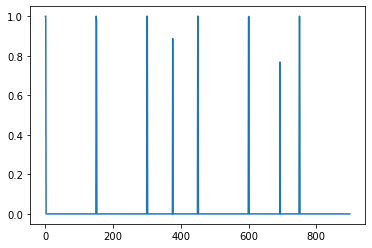

In [547]:
# print(np.argmax(mean_probabilities))
plt.plot(mean_probabilities)

In [541]:
np.mean(mean_probabilities), np.std(mean_probabilities)

(0.018346636, 0.12074306)

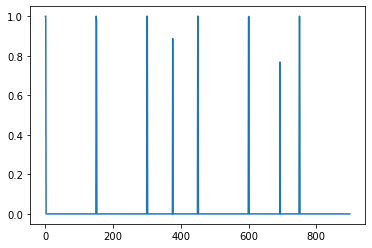

In [548]:
most_likely_kills = mean_probabilities
most_likely_kills[most_likely_kills < 0.5] = 0.0
plt.plot(most_likely_kills)

In [551]:
indices, values = [], []
for j in range(len(most_likely_kills)):
    if most_likely_kills[j] > 0.95:
        indices.append(j)
        values.append(most_likely_kills[j])
print(indices, values)

[0, 1, 150, 151, 300, 301, 450, 451, 600, 601, 750, 751] [0.9999946, 0.99999994, 0.9999964, 0.9808084, 0.99999934, 0.99998957, 0.99997115, 0.99999744, 0.99591404, 0.99880403, 0.9999922, 0.9981129]


In [553]:
np.mean(values), np.std(values), np.max(values), np.min(values)

(0.9977984, 0.005258627, 0.99999994, 0.9808084)

0.9999922
(720, 1280, 3)


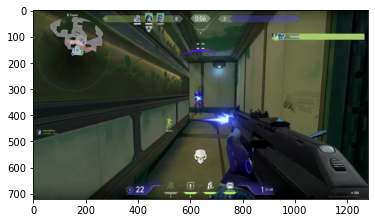

In [555]:
def show_(index, mean_probabilities, compilation_images_path):
    img = cv2.imread(compilation_frames_path + 'kill' + str(index) + '.jpg')
    print(mean_probabilities[index])
    print(img.shape)
    plt.imshow(img)
show_(750, mean_probabilities, compilation_frames_path)
#By inspection it seems that predictions> 0.95 have the best fit

In [39]:
#Generate the actual kill compilation video    

# def generate_kill_compilation(compilation_images_folder, finished_video):
    
#     shape = (720, 1280)

#     fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# #     fourcc = cv2.CV_FOURCC(*'XVID') 
# #     cv2.VideoWriter(video_name, 0, 1, (width, height))  
#     output = cv2.VideoWriter(finished_video, fourcc, 15, shape)
     
#     directory = os.listdir(compilation_images_folder)
        
    
#     for i in range(len(directory)):
        
#         img = cv2.imread(compilation_images_folder + 'kill' + str(i) + '.jpg')
       
#         output.write(img)
#     cv2.destroyAllWindows()
#     output.release()
import glob

compilation_frames_path = '/media/dolan/Backup Plus/Valorant/compilation_images/'

img_array = []
count = 0
for filename in glob.glob('/media/dolan/Backup Plus/Valorant/compilation_images/*.jpg'):
    if count % 50 == 0:
        print('Getting there....')
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    count += 1
    

Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....
Getting there....


In [42]:
video_path = '/media/dolan/Backup Plus/Valorant/kill_compilation.mp4'

out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

# generate_kill_compilation(compilation_frames_path, video_path)

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [37]:
compilation_frames_folder

NameError: name 'compilation_frames_folder' is not defined

In [571]:
# Create a VideoCapture object and read from input file
cap = cv2.VideoCapture('/media/dolan/Backup Plus/Valorant/kill_compilation.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video file")

while(cap.isOpened()):
     
# Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
    # Display the resulting frame
        cv2.imshow('Frame', frame)
         
    # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    else:
        break
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [313]:
region_of_interest.shape
# plt.imshow(region_of_interest)
frame =  cv2.imread(video_frames_path + 'frame' + str(38350) + '.jpg')
# region_of_interest = cv2.resize(sample_img, (320, 180))
region_of_interest = frame[520:590, :][:,600:685]#[130:150, :][:,150:170]
region_of_interest = cv2.resize(region_of_interest, (40, 40))
# input_ = cv2.resize(region_of_interest, )
input_ = np.expand_dims(region_of_interest, axis=0)
reg = model.predict(input_)

1/1 [==============================] - 0s 33ms/step


(array([[1.]], dtype=float32), <matplotlib.image.AxesImage at 0x7f09ab61baf0>)

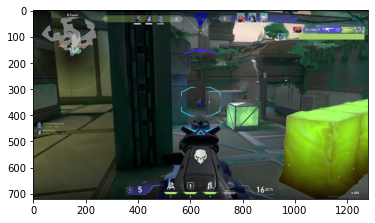

In [314]:
# plt.imshow(frame[520:590, :][:,600:685])
# plt.imshow(region_of_interest), video_frames_path
reg, plt.imshow(frame)

In [247]:
input_ = np.expand_dims(region_of_interest, axis=0)
reg = model.predict(input_)

1/1 [==============================] - 0s 18ms/step


In [277]:
len(os.listdir(video_frames_path))

55353

In [322]:
frame =  cv2.imread(compilation_frames_path + 'kill' + str(2) + '.jpg')
# region_of_interest = cv2.resize(sample_img, (320, 180))
region_of_interest = frame[520:590, :][:,600:685]#[130:150, :][:,150:170]
region_of_interest = cv2.resize(region_of_interest, (40, 40))
# input_ = cv2.resize(region_of_interest, )
input_ = np.expand_dims(region_of_interest, axis=0)
reg = model.predict(input_)

1/1 [==============================] - 0s 39ms/step


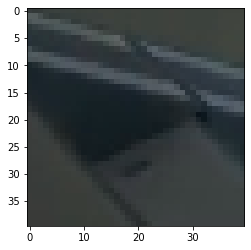

In [325]:
plt.imshow(region_of_interest)

In [586]:
model.save('/home/dolan/Desktop/DataScience/kaggle/kill_cam.h5')